### Install necessary packages

In [1]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install pytorch-lightning

     -------------------------------------- 827.8/827.8 KB 4.0 MB/s eta 0:00:00
     -------------------------------------- 153.2/153.2 KB 2.3 MB/s eta 0:00:00
     -------------------------------------- 519.2/519.2 KB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: yarl<2.0,>=1.0 in c:\users\user\appdata\local\programs\python\python37\lib\site-packages (from aiohttp->fsspec[http]>2021.06.0->pytorch-lightning) (1.7.2)



You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.3.1
    Uninstalling PyYAML-5.3.1:
      Successfully uninstalled PyYAML-5.3.1
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 1.6.0
    Uninstalling importlib-metadata-1.6.0:
      Successfully uninstalled importlib-metadata-1.6.0


### Import packages

In [3]:
import nltk

In [4]:
# For data-preprocessing
import re
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For training
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertModel, BertTokenizer, AdamW

RANDOM_SEED = 4263
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# device = torch.device("gpu" if torch.cuda.is_available() else "cpu")

### Load and do basic cleaning of raw data

In [5]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

HTML_PATTERN = re.compile('<.*?>')
nltk.download('stopwords')
STOPWORDS_LIST = set(stopwords.words('english'))

def noise_entity_removal(target_input):
    # convert to lower case
    target_input = target_input.lower()
    
    # remove html tags
    target_input = re.sub(HTML_PATTERN, ' ', target_input)
    
    # remove non-word characters like #,*,% etc
    target_input = re.sub(r'\W',' ', target_input)
    
    #will remove digits
    target_input = re.sub(r'\d',' ',target_input)
    
    #will remove extra spaces
    target_input = re.sub(r'\s+',' ',target_input)
    
    # remove stopwords
    # target_input_tokens = nltk.word_tokenize(target_input)
    # target_input_tokens_wo_stopwords = [i for i in target_input_tokens if i not in STOPWORDS_LIST and i]
    
    # join the list of tokens back to string
    # output = " ".join(target_input_tokens_wo_stopwords)
    
    return target_input

def label_to_integer(sentiment_label):
    if sentiment_label == 'positive':
        return 1
    elif sentiment_label == 'negative':
        return 0
    else:
        return None

full_data = pd.read_csv('../../data/raw/reviews.csv') # link to file to be changed later
full_data['processed_text'] = full_data['Text'].apply(lambda x:noise_entity_removal(x))
full_data['Sentiment'] = full_data['Sentiment'].apply(lambda x:label_to_integer(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Some minor EDAs

In [6]:
full_data.columns

Index(['Sentiment', 'Time', 'Text', 'processed_text'], dtype='object')

In [7]:
full_data.head()

,Sentiment,Time,Text,processed_text
0,1,18/6/21,This is a very healthy dog food. Good for thei...,this is a very healthy dog food good for their...
1,1,7/7/21,I've been very pleased with the Natural Balanc...,i ve been very pleased with the natural balanc...
2,1,18/6/21,"Before I was educated about feline nutrition, ...",before i was educated about feline nutrition i...
3,1,7/7/21,"My holistic vet recommended this, along with a...",my holistic vet recommended this along with a ...
4,1,1/7/21,I bought this coffee because its much cheaper ...,i bought this coffee because its much cheaper ...


Text(0.5, 1.0, 'Count of negative vs positive reviews')

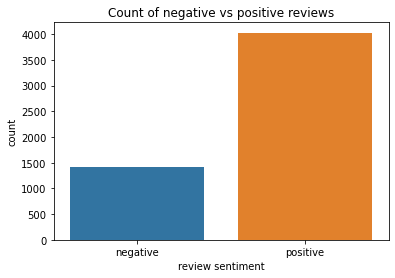

In [8]:
ax=sns.countplot(x=full_data.Sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(['negative', 'positive'])
plt.title('Count of negative vs positive reviews')

Number of review more than 2000 words:  20


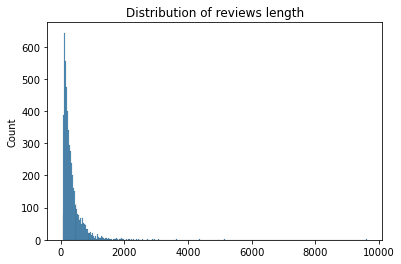

In [9]:
review_lengths = [len(x) for x in full_data['processed_text']]
sns.histplot(review_lengths)
plt.title('Distribution of reviews length')
# most reviews are below 2000
print('Number of review more than 2000 words: ',sum([1 if x > 2000 else 0 for x in review_lengths]))

### HYPERPARAMETERS

In [10]:
PRETRAINED_MODEL_NAME = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [11]:
len(full_data)

5444

In [12]:
PARAMETERS = {
    "max_review_length": 512,
    "batch_size": 32,
    "test_size": 0.1,
    "val_size": 0.1,
    "dropout_rate": 0.2,
    "n_classes": 2,
    "random_seed": 4263,
    "learning_rate": 0.001,
    "trainer_kwargs": {
        "max_epochs": 10,
        "check_val_every_n_epoch": 1,
        "log_every_n_steps": 1
    }
}

In [13]:
MAX_REVIEW_LENGTH = PARAMETERS["max_review_length"]
BATCH_SIZE = PARAMETERS["batch_size"]
TEST_SIZE = PARAMETERS["test_size"]
VAL_SIZE = PARAMETERS["val_size"]
DROPOUT_RATE = PARAMETERS["dropout_rate"]
N_CLASSES = PARAMETERS['n_classes']

### CREATE THE TORCH DATASET

In [14]:
class ReviewDataset(Dataset):
  def __init__(self, reviews, sentiments, tokenizer, max_review_len):
    """
    reviews: np.array
    sentiments: np.array
    """
    self.reviews = reviews
    self.sentiments = sentiments
    self.tokenizer = tokenizer # this must be the bert tokenizer
    self.max_review_len = max_review_len

  def __len__(self):
    return len(self.sentiments)

  def __getitem__(self, idx):
    review = str(self.reviews[idx])
    sentiment = self.sentiments[idx]

    bert_encoding = self.tokenizer.encode_plus(
        review,
        max_length = self.max_review_len,
        pad_to_max_length = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors='pt'
    )
    return {
        'review': review,
        'token_ids': bert_encoding['input_ids'].flatten(),
        'attention_mask': bert_encoding['attention_mask'].flatten(),
        'sentiment': torch.tensor(sentiment)
    }

In [17]:
# class GenReviewDataloader:
#   def __init__(self, data, test_size, val_size, tokenizer, batch_size, max_review_len):
#     self.data = data # pd.Dataframe
#     self.test_size = test_size,
#     self.val_size = val_size,
#     self.tokenizer = tokenizer,
#     self.batch_size = batch_size,
#     self.max_review_len = max_review_len
  
#     trainval, self.df_test = train_test_split(
#         data, test_size=self.test_size, random_state = RANDOM_SEED
#     )
#     self.df_train, self.df_val = train_test_split(
#         trainval, test_size=val_size
#     )
#   def create_dataloader(self, pp):
#     if pp == 'train':
#       df = ReviewDataset(
#         reviews = torch.tensor(self.df_train['processed_text'].values),
#         sentiments = torch.tensor(self.df_train['Sentiment'].values),
#         tokenizer = self.tokenizer,
#         max_review_len = self.max_review_len
#       )
#       return DataLoader(df, batch_size=self.batch_size, num_workers=4)
#     elif pp == 'test':
#       df = ReviewDataset(
#         reviews = torch.tensor(self.df_test['processed_text'].values),
#         sentiments = torch.tensor(self.df_test['Sentiment'].values),
#         tokenizer = self.tokenizer,
#         max_review_len = self.max_review_len
#       )
#       return DataLoader(df, batch_size=self.batch_size, num_workers=3)
#     else:
#       df = ReviewDataset(
#         reviews = torch.tensor(self.df_val['processed_text'].values),
#         sentiments = torch.tensor(self.df_val['Sentiment'].values),
#         tokenizer = self.tokenizer,
#         max_review_len = self.max_review_len
#       )
#       return DataLoader(df, batch_size=self.batch_size, num_workers=2)


In [18]:
# data_helper = GenReviewDataloader(full_data, test_size=TEST_SIZE, val_size=VAL_SIZE, tokenizer=bert_tokenizer, batch_size=BATCH_SIZE, max_review_len=MAX_REVIEW_LENGTH)
# train_dataloader = data_helper.create_dataloader('train')
# test_dataloader = data_helper.create_dataloader('test')
# val_dataloader = data_helper.create_dataloader('val')
  # def prepare_data(self):
  #   self.full_df = ReviewDataset( # full_df: class ReviewDataset
  #     reviews = torch.tensor(self.data['processed_text'].values),
  #     sentiments = torch.tensor(self.data['Sentiment'].values),
  #     tokenizer = self.tokenizer,
  #     max_review_len = self.max_review_len
  #   )

### CREATE PYTORCH LIGHTNING DATAMODULE

In [15]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

class ReviewDataModule(pl.LightningDataModule):
  def __init__(self, dataset, val_size, batch_size):
    super().__init__()
    self.dataset = dataset # ReviewDataset
    self.val_size = val_size,
    self.batch_size = batch_size

    if val_size is not None:
      dataset_size = len(self.dataset)
      indices = list(range(dataset_size))
      split = int(np.floor(val_size * dataset_size))
      train_indices, val_indices = indices[split:], indices[:split]
      self.train_sampler = SubsetRandomSampler(train_indices)
      self.valid_sampler = SubsetRandomSampler(val_indices)
  
  def train_dataloader(self):
    return DataLoader(self.dataset, batch_size=self.batch_size, num_workers=0, sampler=self.train_sampler, shuffle=False)

  def val_dataloader(self):
    return DataLoader(self.dataset, batch_size=self.batch_size, num_workers=0, sampler=self.valid_sampler, shuffle=False)


## SENTIMENT ANALYSIS WITH BASIC BERT

In [16]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes, dropout_rate):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)
    self.dropout = nn.Dropout(p=dropout_rate)
    self.linear_out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, token_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = token_ids,
        attention_mask = attention_mask,
        return_dict = False
    )
    output = self.dropout(pooled_output)
    return self.linear_out(output)

In [17]:
import torch
class SentimentModel(pl.LightningModule):
  def __init__(self, parameters, tokenizer):
    super().__init__()
    self.tokenizer = tokenizer
    self.random_seed = parameters["random_seed"]
    pl.seed_everything(self.random_seed, workers = True)
    self.learning_rate = parameters["learning_rate"]
    self.dropout_rate = parameters["dropout_rate"]
    self.loss = nn.CrossEntropyLoss()
    self.max_review_length = parameters["max_review_length"]
    self.batch_size = parameters["batch_size"]
    self.val_size = parameters["val_size"]
    self.predict_size = 1 # predict 1 review at a time
    self.n_classes = parameters["n_classes"]
    self.trainer_kwargs = parameters["trainer_kwargs"]
    self.model = SentimentClassifier(n_classes=self.n_classes, dropout_rate=self.dropout_rate)
    
    self.training_losses = []
    self.validation_losses = []
    self.val_accuracies = []
    self.train_accuracies = []
    self.train_correct_preds = 0
    self.val_correct_preds = 0
    self.train_correct_preds_list = []
    self.val_correct_preds_list = []
    if torch.cuda.is_available():
      self.trainer_kwargs["accelerator"] = "gpu"
      self.trainer_kwargs["devices"] = -1

  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

  def training_step(self, batch, batch_idx):
    token_ids = batch["token_ids"]#.to(device)
    attention_mask = batch["attention_mask"]#.to(device)
    sentiments = batch["sentiment"]#.to(device)

    outputs = self.model(token_ids, attention_mask)
    _, predictions = torch.max(outputs, dim=1)

    loss = self.loss(outputs, sentiments)
    self.training_losses.append(loss.item())
    self.train_correct_preds += torch.sum(predictions == sentiments)
    nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
    return loss 

  def validation_step(self, batch, batch_idx):
    token_ids = batch["token_ids"]#.to(device)
    attention_mask = batch["attention_mask"]#.to(device)
    sentiments = batch["sentiment"]#.to(device)

    outputs = self.model(token_ids, attention_mask)
    _, predictions = torch.max(outputs, dim=1)

    loss = self.loss(outputs, sentiments)
    self.validation_losses.append(loss.item())
    self.val_correct_preds += torch.sum(predictions == sentiments)
    return loss 

  def on_validation_epoch_end(self):
      self.val_correct_preds_list.append(self.val_correct_preds.double())
      self.val_correct_preds = 0

  def on_train_epoch_end(self):
    self.train_correct_preds_list.append(self.train_correct_preds.double())
    self.train_correct_preds = 0

  def predict_step(self, batch, batch_idx):
    token_ids = batch["token_ids"]#.to(device)
    attention_mask = batch["attention_mask"]#.to(device)
    sentiments = batch["sentiment"]#.to(device)

    outputs = self.model(token_ids, attention_mask)
    _, predictions = torch.max(outputs, dim=1)
    return predictions

  def fit(self, data):
    """data: pd.DataFrame with both X and y"""
    dataset = ReviewDataset(
      reviews = data['processed_text'].values,
      sentiments = data['Sentiment'].values,
      tokenizer = self.tokenizer,
      max_review_len = self.max_review_length
    )
    dm = ReviewDataModule(dataset, val_size=self.val_size, batch_size=self.batch_size)
    trainer = pl.Trainer(**self.trainer_kwargs)
    trainer.fit(self, datamodule = dm)

  def predict(self, data): # for the left-out testset
    dataset = ReviewDataset(
      reviews = torch.tensor(data['processed_text'].values),
      sentiments = torch.tensor(data['Sentiment'].values),
      tokenizer = self.tokenizer,
      max_review_len = self.max_review_length
    )
    dm = ReviewDataModule(dataset, val_size=None, batch_size=self.predict_size)
    
    trainer = pl.Trainer(**self.trainer_kwargs)
    preds = trainer.predict(self, datamodule=dm)
    return preds




## TRAINING

In [18]:
full_data

,Sentiment,Time,Text,processed_text
0,1,18/6/21,This is a very healthy dog food. Good for thei...,this is a very healthy dog food good for their...
1,1,7/7/21,I've been very pleased with the Natural Balanc...,i ve been very pleased with the natural balanc...
2,1,18/6/21,"Before I was educated about feline nutrition, ...",before i was educated about feline nutrition i...
3,1,7/7/21,"My holistic vet recommended this, along with a...",my holistic vet recommended this along with a ...
4,1,1/7/21,I bought this coffee because its much cheaper ...,i bought this coffee because its much cheaper ...
...,...,...,...,...
5439,0,26/2/21,"This is an okay gift box, only if you like med...",this is an okay gift box only if you like medi...
5440,0,18/12/19,It looks llike I just walked into a raw deal. ...,it looks llike i just walked into a raw deal t...
5441,0,19/1/20,Thank god that i tasted the metal before i swa...,thank god that i tasted the metal before i swa...
5442,0,13/9/20,This product was very good when I began buying...,this product was very good when i began buying...


In [19]:
df_train, df_test = train_test_split(full_data, test_size=TEST_SIZE, random_state=RANDOM_SEED)

##### Define and Train model

In [20]:
import time
model = SentimentModel(parameters=PARAMETERS, tokenizer=bert_tokenizer)


starttime = time.time()
model.fit(df_train)
endtime = time.time()
print(endtime - starttime)

Global seed set to 4263
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, 

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\transformers\tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be re

c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 0:   0%|          | 0/154 [00:00<?, ?it/s] 

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 402653184 bytes.

In [ ]:
model.save('bert1.ckpt')